In [14]:
import torch
import torch.nn.functional as F

# def get_gradient(image):
#     # Compute gradients with Sobel filters
#     sobel_x = torch.tensor([[-1., 0., 1.],
#                              [-2., 0., 2.],
#                              [-1., 0., 1.]])
    
#     sobel_y = torch.tensor([[-1., -2., -1.],
#                              [ 0.,  0.,  0.],
#                              [ 1.,  2.,  1.]])
    
#     sobel_x = sobel_x.unsqueeze(0).unsqueeze(0)  # shape [1, 1, 3, 3]
#     sobel_y = sobel_y.unsqueeze(0).unsqueeze(0)

#     gx = F.conv2d(image, sobel_x, padding=1).squeeze()
#     gy = F.conv2d(image, sobel_y, padding=1).squeeze()

#     return gx, gy

# def gaussian_kernel(kernel_size: int, sigma: float) -> torch.Tensor:
#     """创建 2D 高斯核 (kernel_size x kernel_size)"""
#     ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
#     xx, yy = torch.meshgrid(ax, ax, indexing='ij')
#     kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
#     kernel = kernel / kernel.sum()
#     return kernel

# def apply_gaussian_blur(img: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
#     """使用给定高斯核对图像进行卷积"""
#     C = img.shape[1]
#     kernel = kernel.expand(C, 1, *kernel.shape)  # 扩展为 (C, 1, k, k)
#     img_blur = F.conv2d(img, kernel, padding=kernel.shape[-1] // 2, groups=C)
#     return img_blur

# def get_gradient_canny(image):
#     kernel = gaussian_kernel(kernel_size=7, sigma=1.5)
#     img_blurred = apply_gaussian_blur(image, kernel)
#     return get_gradient(img_blurred)

def get_gradient(image):
    dim = image.dim()
    if dim == 3:
        image = image.unsqueeze(0)
    if dim == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    
    # Compute gradients with Sobel filters
    sobel_x = torch.tensor([[-1., 0., 1.],
                             [-2., 0., 2.],
                             [-1., 0., 1.]])
    
    sobel_y = torch.tensor([[-1., -2., -1.],
                             [ 0.,  0.,  0.],
                             [ 1.,  2.,  1.]])
    
    sobel_x = sobel_x.unsqueeze(0).unsqueeze(0)  # shape [1, 1, 3, 3]
    sobel_y = sobel_y.unsqueeze(0).unsqueeze(0)

    gx = F.conv2d(image, sobel_x, padding=1)
    gy = F.conv2d(image, sobel_y, padding=1)

    if dim == 3:
        return gx.squeeze(0), gy.squeeze(0)
    if dim == 2:
        return gx.squeeze(0).squeeze(0), gy.squeeze(0).squeeze(0)
    return gx, gy

def gaussian_kernel(kernel_size: int, sigma: float) -> torch.Tensor:
    """创建 2D 高斯核 (kernel_size x kernel_size)"""
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

def apply_gaussian_blur(img: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """使用给定高斯核对图像进行卷积"""
    C = img.shape[1]
    kernel = kernel.expand(C, 1, *kernel.shape)  # 扩展为 (C, 1, k, k)
    img_blur = F.conv2d(img, kernel, padding=kernel.shape[-1] // 2, groups=C)
    return img_blur

def get_gradient_canny(image):
    dim = image.dim()
    if dim == 3:
        image = image.unsqueeze(0)
    if dim == 2:
        image = image.unsqueeze(0).unsqueeze(0)

    kernel = gaussian_kernel(kernel_size=7, sigma=1.5)
    img_blurred = apply_gaussian_blur(image, kernel)
    gx, gy = get_gradient(img_blurred)

    if dim == 3:
        return gx.squeeze(0), gy.squeeze(0)
    if dim == 2:
        return gx.squeeze(0).squeeze(0), gy.squeeze(0).squeeze(0)
    return gx, gy

In [2]:
import cv2
import numpy as np

def deriche_filter_1d(signal, alpha):
    """
    对一维信号应用Deriche递归滤波，返回滤波后信号
    参考经典公式：
    y[i] = a1*x[i] + a2*x[i-1] + b1*y[i-1] + b2*y[i-2]
    以及对应反向滤波
    """
    N = len(signal)
    y = np.zeros(N, dtype=np.float32)
    y_rev = np.zeros(N, dtype=np.float32)

    # 计算参数（依据论文Deriche 1987）
    e_minus_alpha = np.exp(-alpha)
    k = (1 - e_minus_alpha)**2 / (1 + 2 * alpha * e_minus_alpha - e_minus_alpha**2)
    a1 = k
    a2 = k * e_minus_alpha * (alpha - 1)
    b1 = 2 * e_minus_alpha
    b2 = - e_minus_alpha ** 2

    # 正向滤波
    y[0] = a1 * signal[0]
    y[1] = a1 * signal[1] + a2 * signal[0] + b1 * y[0]
    for i in range(2, N):
        y[i] = a1 * signal[i] + a2 * signal[i-1] + b1 * y[i-1] + b2 * y[i-2]

    # 反向滤波
    y_rev[-1] = 0
    y_rev[-2] = a2 * signal[-1]
    for i in range(N-3, -1, -1):
        y_rev[i] = a1 * signal[i+1] + a2 * signal[i+2] + b1 * y_rev[i+1] + b2 * y_rev[i+2]

    return y + y_rev


import numpy as np

def deriche_gradient(img, alpha=1.0):
    """
    输入：
        img: 2D灰度图 numpy数组，float32类型
        alpha: 平滑参数，通常取 0.5 ~ 3
    
    输出：
        gx, gy: 图像X和Y方向梯度
    """
    h, w = img.shape

    # 沿列做滤波（垂直方向）
    vertical_filtered = np.zeros_like(img, dtype=np.float32)
    for x in range(w):
        vertical_filtered[:, x] = deriche_filter_1d(img[:, x], alpha)

    # 沿行做滤波（水平微分方向）
    gx = np.zeros_like(img, dtype=np.float32)
    for y in range(h):
        gx[y, :] = deriche_filter_1d(vertical_filtered[y, :], alpha)

    # 对于y方向梯度，先沿行滤波
    horizontal_filtered = np.zeros_like(img, dtype=np.float32)
    for y in range(h):
        horizontal_filtered[y, :] = deriche_filter_1d(img[y, :], alpha)

    # 再沿列滤波，得到y梯度
    gy = np.zeros_like(img, dtype=np.float32)
    for x in range(w):
        gy[:, x] = deriche_filter_1d(horizontal_filtered[:, x], alpha)

    return gx, gy

In [11]:
import numpy as np
import itertools
from tqdm import tqdm
import math

# Retourne norm sans les valeurs non maximales locales (on ne garde que les lignes de crêtes)
def no_maxima_suppression(norm, pente_x, pente_y, silent=False):
	new_norm = np.zeros(norm.shape)
	
	rng = itertools.product(range(1, norm.shape[0]-1), range(1, norm.shape[1]-1))
	if not silent:
		rng = tqdm(rng, total=(norm.shape[0]-2)**2) #, leave=False)
	# if not silent:
	# 	rng = t_itertools.product(range(1, norm.shape[0]-1), range(1, norm.shape[1]-1), leave=False)
	# else:
	# 	rng = itertools.product(range(1, norm.shape[0]-1), range(1, norm.shape[1]-1))
	
	for i, j in rng:
		if pente_y[i][j] != 0:
			wd = pente_x[i][j] / pente_y[i][j]
			
			if wd >= 1:
				(ia1, ia2, ja1, ja2) = (i, i+1, j+1, j+1)
				(ib1, ib2, jb1, jb2) = (i, i-1, j-1, j-1)
				wd = 1/wd
			elif wd >= 0:
				(ia1, ia2, ja1, ja2) = (i+1, i+1, j, j+1)
				(ib1, ib2, jb1, jb2) = (i-1, i-1, j, j-1)
			elif wd >= -1:
				(ia1, ia2, ja1, ja2) = (i+1, i+1, j, j-1)
				(ib1, ib2, jb1, jb2) = (i-1, i-1, j, j+1)
			else:
				(ia1, ia2, ja1, ja2) = (i, i+1, j-1, j-1)
				(ib1, ib2, jb1, jb2) = (i, i-1, j+1, j+1)
				wd = 1/wd
			
			if pente_y[i][j] < 0:
				temp = (ia1, ia2, ja1, ja2)
				(ia1, ia2, ja1, ja2) = (ib1, ib2, jb1, jb2)
				(ib1, ib2, jb1, jb2) = temp
				
			a = norm[ia1][ja1] + (norm[ia2][ja2] - norm[ia1][ja1]) * wd
			b = norm[ib1][jb1] + (norm[ib2][jb2] - norm[ib1][jb1]) * wd
			
		else: # ie pente_y[i][j] == 0
			if pente_x[i][j] == 0:
				new_norm[i][j] = norm[i][j]
				continue
			else:
				if pente_x[i][j] < 0:
					ja = j+1
					jb = j-1
				else: # ie pente_x[i][j] > 0
					ja = j-1
					jb = j+1
				
				a = norm[i][ja]
				b = norm[i][jb]
				
		if norm[i][j] <= a or norm[i][j] < b:
			new_norm[i][j] = 0
			continue
		
		new_norm[i][j] = norm[i][j]
	
	new_norm[0][:] = new_norm[-1][:] = new_norm[:][0] = new_norm[:][-1] = 0
	
	return new_norm


# 尝试torch版本
import torch

def nms_torch(norm, pente_x, pente_y):
    """
    norm, pente_x, pente_y: shape (H, W) or (N, H, W), torch.Tensor, float32或float64，设备支持CPU/GPU
    返回：new_norm，和输入尺寸一致
    """

    if norm.dim() == 2:
        norm = norm.unsqueeze(0)
        pente_x = pente_x.unsqueeze(0)
        pente_y = pente_y.unsqueeze(0)
        squeeze_output = True
    else:
        squeeze_output = False

    N, H, W = norm.shape
    device = norm.device

    new_norm = torch.zeros_like(norm)

    # 为避免除零，替换0为小数
    gy_safe = pente_y.clone()
    gy_safe[gy_safe == 0] = 1e-10

    wd = pente_x / gy_safe

    # 初始化a,b张量
    a = torch.zeros_like(norm)
    b = torch.zeros_like(norm)

    # 构造网格索引
    i = torch.arange(0, H, device=device).view(-1, 1).expand(H, W)
    j = torch.arange(0, W, device=device).view(1, -1).expand(H, W)

    # 处理边界时避免越界，先clip索引
    def clip(x, lower, upper):
        return torch.clamp(x, lower, upper)

    # 4个方向的mask
    mask1 = wd >= 1
    mask2 = (wd >= 0) & (wd < 1)
    mask3 = (wd >= -1) & (wd < 0)
    mask4 = wd < -1
    mask_gy_neg = pente_y < 0

    # 对单张图执行插值计算（多张可扩展）
    for n in range(N):
        norm_n = norm[n]
        pente_x_n = pente_x[n]
        pente_y_n = pente_y[n]
        wd_n = wd[n]

        a_n = torch.zeros_like(norm_n)
        b_n = torch.zeros_like(norm_n)

        # mask1: wd >= 1
        idx_mask = mask1[n]
        if idx_mask.any():
            wd1 = torch.zeros_like(wd_n)
            wd1[idx_mask] = 1 / wd_n[idx_mask]

            ia1 = clip(i[idx_mask], 0, H - 1)
            ia2 = clip(i[idx_mask] + 1, 0, H - 1)
            ja1 = clip(j[idx_mask] + 1, 0, W - 1)
            ja2 = clip(j[idx_mask] + 1, 0, W - 1)

            ib1 = clip(i[idx_mask], 0, H - 1)
            ib2 = clip(i[idx_mask] - 1, 0, H - 1)
            jb1 = clip(j[idx_mask] - 1, 0, W - 1)
            jb2 = clip(j[idx_mask] - 1, 0, W - 1)

            a_val = norm_n[ia1, ja1] + (norm_n[ia2, ja2] - norm_n[ia1, ja1]) * wd1[idx_mask]
            b_val = norm_n[ib1, jb1] + (norm_n[ib2, jb2] - norm_n[ib1, jb1]) * wd1[idx_mask]

            a_n[idx_mask] = a_val
            b_n[idx_mask] = b_val

        # mask2: 0 <= wd < 1
        idx_mask = mask2[n]
        if idx_mask.any():
            ia1 = clip(i[idx_mask] + 1, 0, H - 1)
            ia2 = clip(i[idx_mask] + 1, 0, H - 1)
            ja1 = clip(j[idx_mask], 0, W - 1)
            ja2 = clip(j[idx_mask] + 1, 0, W - 1)

            ib1 = clip(i[idx_mask] - 1, 0, H - 1)
            ib2 = clip(i[idx_mask] - 1, 0, H - 1)
            jb1 = clip(j[idx_mask], 0, W - 1)
            jb2 = clip(j[idx_mask] - 1, 0, W - 1)

            a_val = norm_n[ia1, ja1] + (norm_n[ia2, ja2] - norm_n[ia1, ja1]) * wd_n[idx_mask]
            b_val = norm_n[ib1, jb1] + (norm_n[ib2, jb2] - norm_n[ib1, jb1]) * wd_n[idx_mask]

            a_n[idx_mask] = a_val
            b_n[idx_mask] = b_val

        # mask3: -1 <= wd < 0
        idx_mask = mask3[n]
        if idx_mask.any():
            ia1 = clip(i[idx_mask] + 1, 0, H - 1)
            ia2 = clip(i[idx_mask] + 1, 0, H - 1)
            ja1 = clip(j[idx_mask], 0, W - 1)
            ja2 = clip(j[idx_mask] - 1, 0, W - 1)

            ib1 = clip(i[idx_mask] - 1, 0, H - 1)
            ib2 = clip(i[idx_mask] - 1, 0, H - 1)
            jb1 = clip(j[idx_mask], 0, W - 1)
            jb2 = clip(j[idx_mask] + 1, 0, W - 1)

            a_val = norm_n[ia1, ja1] + (norm_n[ia2, ja2] - norm_n[ia1, ja1]) * wd_n[idx_mask]
            b_val = norm_n[ib1, jb1] + (norm_n[ib2, jb2] - norm_n[ib1, jb1]) * wd_n[idx_mask]

            a_n[idx_mask] = a_val
            b_n[idx_mask] = b_val

        # mask4: wd < -1
        idx_mask = mask4[n]
        if idx_mask.any():
            wd4 = torch.zeros_like(wd_n)
            wd4[idx_mask] = 1 / wd_n[idx_mask]

            ia1 = clip(i[idx_mask], 0, H - 1)
            ia2 = clip(i[idx_mask] + 1, 0, H - 1)
            ja1 = clip(j[idx_mask] - 1, 0, W - 1)
            ja2 = clip(j[idx_mask] - 1, 0, W - 1)

            ib1 = clip(i[idx_mask], 0, H - 1)
            ib2 = clip(i[idx_mask] - 1, 0, H - 1)
            jb1 = clip(j[idx_mask] + 1, 0, W - 1)
            jb2 = clip(j[idx_mask] + 1, 0, W - 1)

            a_val = norm_n[ia1, ja1] + (norm_n[ia2, ja2] - norm_n[ia1, ja1]) * wd4[idx_mask]
            b_val = norm_n[ib1, jb1] + (norm_n[ib2, jb2] - norm_n[ib1, jb1]) * wd4[idx_mask]

            a_n[idx_mask] = a_val
            b_n[idx_mask] = b_val

        # pente_y < 0 时交换 a,b
        idx_mask = mask_gy_neg[n]
        if idx_mask.any():
            temp = a_n[idx_mask].clone()
            a_n[idx_mask] = b_n[idx_mask]
            b_n[idx_mask] = temp

        # pente_y==0 且 pente_x==0 直接保留 norm
        zero_grad_mask = (pente_x_n == 0) & (pente_y_n == 0)
        new_norm[n][zero_grad_mask] = norm_n[zero_grad_mask]

        # 其他情况非极大值置零
        keep_mask = (norm_n >= a_n) & (norm_n > b_n) & (~zero_grad_mask)
        new_norm[n][keep_mask] = norm_n[keep_mask]

    # 边界设置为0
    new_norm[:, 0, :] = 0
    new_norm[:, -1, :] = 0
    new_norm[:, :, 0] = 0
    new_norm[:, :, -1] = 0

    if squeeze_output:
        return new_norm.squeeze(0)
    else:
        return new_norm



import torch
import torch.nn.functional as F

def nms_fully_vectorized(norm, pente_x, pente_y):
    """
    Fully vectorized NMS with directional interpolation for (N, H, W) inputs.
    Returns a tensor of the same shape as norm.
    """

    if norm.dim() == 2:
        norm = norm.unsqueeze(0)
        pente_x = pente_x.unsqueeze(0)
        pente_y = pente_y.unsqueeze(0)
        squeeze_out = True
    else:
        squeeze_out = False

    N, H, W = norm.shape
    device = norm.device

    eps = 1e-10
    gy_safe = pente_y.clone()
    gy_safe[gy_safe == 0] = eps
    wd = pente_x / gy_safe  # (N, H, W)

    a = torch.zeros_like(norm)
    b = torch.zeros_like(norm)

    # -------- Shifted versions of norm (8 directions) --------
    def shift(x, dy, dx):
        # shift x by (dy, dx), pad with 0
        return F.pad(x, (1, 1, 1, 1), mode='constant')[..., 1+dy:H+1+dy, 1+dx:W+1+dx]

    n  = norm
    n_up       = shift(n, -1,  0)
    n_down     = shift(n,  1,  0)
    n_left     = shift(n,  0, -1)
    n_right    = shift(n,  0,  1)
    n_upleft   = shift(n, -1, -1)
    n_upright  = shift(n, -1,  1)
    n_downleft = shift(n,  1, -1)
    n_downright= shift(n,  1,  1)

    # ---------- Build masks ----------
    mask1 = wd >= 1
    mask2 = (wd >= 0) & (wd < 1)
    mask3 = (wd >= -1) & (wd < 0)
    mask4 = wd < -1
    gy_neg = pente_y < 0

    # ---- mask1: wd >= 1 (↘ ↖)，取 (i,j+1)->(i+1,j+1) and (i,j-1)->(i-1,j-1)
    wd1 = torch.zeros_like(wd)
    wd1[mask1] = 1 / wd[mask1]

    a1 = n_right + (n_downright - n_right) * wd1
    b1 = n_left + (n_upleft - n_left) * wd1

    # ---- mask2: 0 <= wd < 1 (→↘ ←↖)
    a2 = n_down + (n_downright - n_down) * wd
    b2 = n_up + (n_upleft - n_up) * wd

    # ---- mask3: -1 <= wd < 0 (→↙ ←↗)
    a3 = n_down + (n_downleft - n_down) * wd
    b3 = n_up + (n_upright - n_up) * wd

    # ---- mask4: wd < -1 (↙ ↗)
    wd4 = torch.zeros_like(wd)
    wd4[mask4] = 1 / wd[mask4]
    a4 = n_left + (n_downleft - n_left) * wd4
    b4 = n_right + (n_upright - n_right) * wd4

    # ---- assemble a, b according to masks ----
    a = torch.where(mask1, a1, a)
    b = torch.where(mask1, b1, b)
    a = torch.where(mask2, a2, a)
    b = torch.where(mask2, b2, b)
    a = torch.where(mask3, a3, a)
    b = torch.where(mask3, b3, b)
    a = torch.where(mask4, a4, a)
    b = torch.where(mask4, b4, b)

    # flip a, b if pente_y < 0
    a_, b_ = a.clone(), b.clone()
    a = torch.where(gy_neg, b_, a)
    b = torch.where(gy_neg, a_, b)

    # If both gradients are 0 → retain original
    zero_grad = (pente_x == 0) & (pente_y == 0)

    # Final suppression decision
    keep = (norm >= a) & (norm > b)
    keep = keep | zero_grad

    out = torch.where(keep, norm, torch.zeros_like(norm))

    # Set borders to 0
    out[:, 0, :] = 0
    out[:, -1, :] = 0
    out[:, :, 0] = 0
    out[:, :, -1] = 0

    return out.squeeze(0) if squeeze_out else out


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from pathlib import Path

project_root = Path("/disk/hd/cosys/intership_2025_COSYS")
image = Image.open(str(project_root / "data/images/real/lena.png")).convert("L")
image = transforms.ToTensor()(image).squeeze()
gx, gy = get_gradient(image.unsqueeze(0).unsqueeze(0))
norm = torch.sqrt(gx**2 + gy**2 + 1e-6)

In [5]:
res1 = no_maxima_suppression(norm, gx, gy)

100%|█████████▉| 228962/229441 [00:18<00:00, 12381.07it/s]


In [20]:
res2 = nms_torch(norm.unsqueeze(0), *get_gradient(image.unsqueeze(0)))

In [22]:
res2.shape

torch.Size([1, 481, 480])

In [6]:
res3 = nms_fully_vectorized(norm, gx, gy)

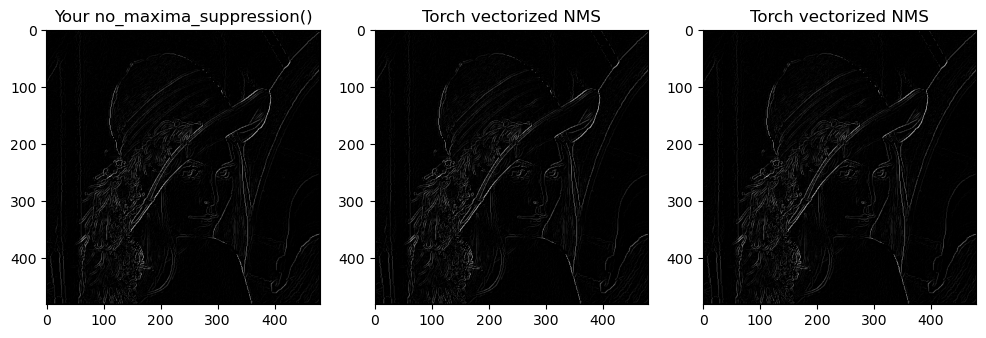

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(res1, cmap='gray')
plt.title('Your no_maxima_suppression()')
plt.subplot(1,3,2)
plt.imshow(res2.cpu(), cmap='gray')
plt.title('Torch vectorized NMS')
plt.subplot(1,3,3)
plt.imshow(res3.cpu(), cmap='gray')
plt.title('Torch vectorized NMS')
plt.show()


In [22]:
(res3 - res2).min()

tensor(0.)

# 加载模型

In [4]:
import sys
from pathlib import Path

project_root = Path("/home/yangk/intership_2025_COSYS")

# 把 Dexined 加入 sys.path
model_dir = project_root / "resource/DexiNed"
if str(model_dir) not in sys.path:
    sys.path.append(str(model_dir))
from model import DexiNed

In [5]:
import torch
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DexiNed()
logging = {
    'metadata': {},
    'train_loss': [],
    'val_loss': []
}
# load model
model.load_state_dict(torch.load(project_root / "demo/demo_Dexined/checkpoints/cpt_visibility_04.pth", weights_only=True))
# load log
with open(project_root / "demo/demo_Dexined/checkpoints/cpt_visibility_04.json", 'r') as f:
    logging = json.load(f)
logging['metadata']

{'description': 'More crazy!!! 200 epoch',
 'num_epoch': 200,
 'batch_size': 8,
 'criterion': 'MSELoss',
 'learning_rate': 0.0001}

# 加载测试集

In [6]:
import sys
# 把 src 加入 sys.path
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))
from dataset import BIPEDv2

data_dir = project_root / "resource/DexiNed/BIPEDv2/BIPED/edges"
test_dataset = BIPEDv2(
    data_dir / "imgs" / "test" / "rgbr",
    data_dir / "edge_maps" / "test" / "rgbr"
)

# 推理

In [7]:
img = test_dataset[0]
x = img['image_tensor']
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

In [8]:
import torchvision.transforms as T
from PIL import Image

org_image = Image.open(img['image_path'] )
edge = Image.open(img['edge_path'] )
transform = T.ToTensor()
# edge_tensor = transform(edge.convert("L"))[0]  # shape [H, W]
img_tensor = transform(org_image.convert("L"))[0]  # shape [H, W]

# Gradient by Sobel

In [ ]:
gt_display = img['visibility_map']
pred_display = yhat

gx, gy = get_gradient(yhat.unsqueeze(0).unsqueeze(0))
pred_nms_display = no_maxima_suppression(yhat, gx, gy)
gx, gy = get_gradient(img_tensor.unsqueeze(0).unsqueeze(0))
pred_nms_with_org_display = no_maxima_suppression(yhat,gx, gy)

917604it [01:21, 11298.39it/s]                            
917604it [01:32, 9890.99it/s]                             


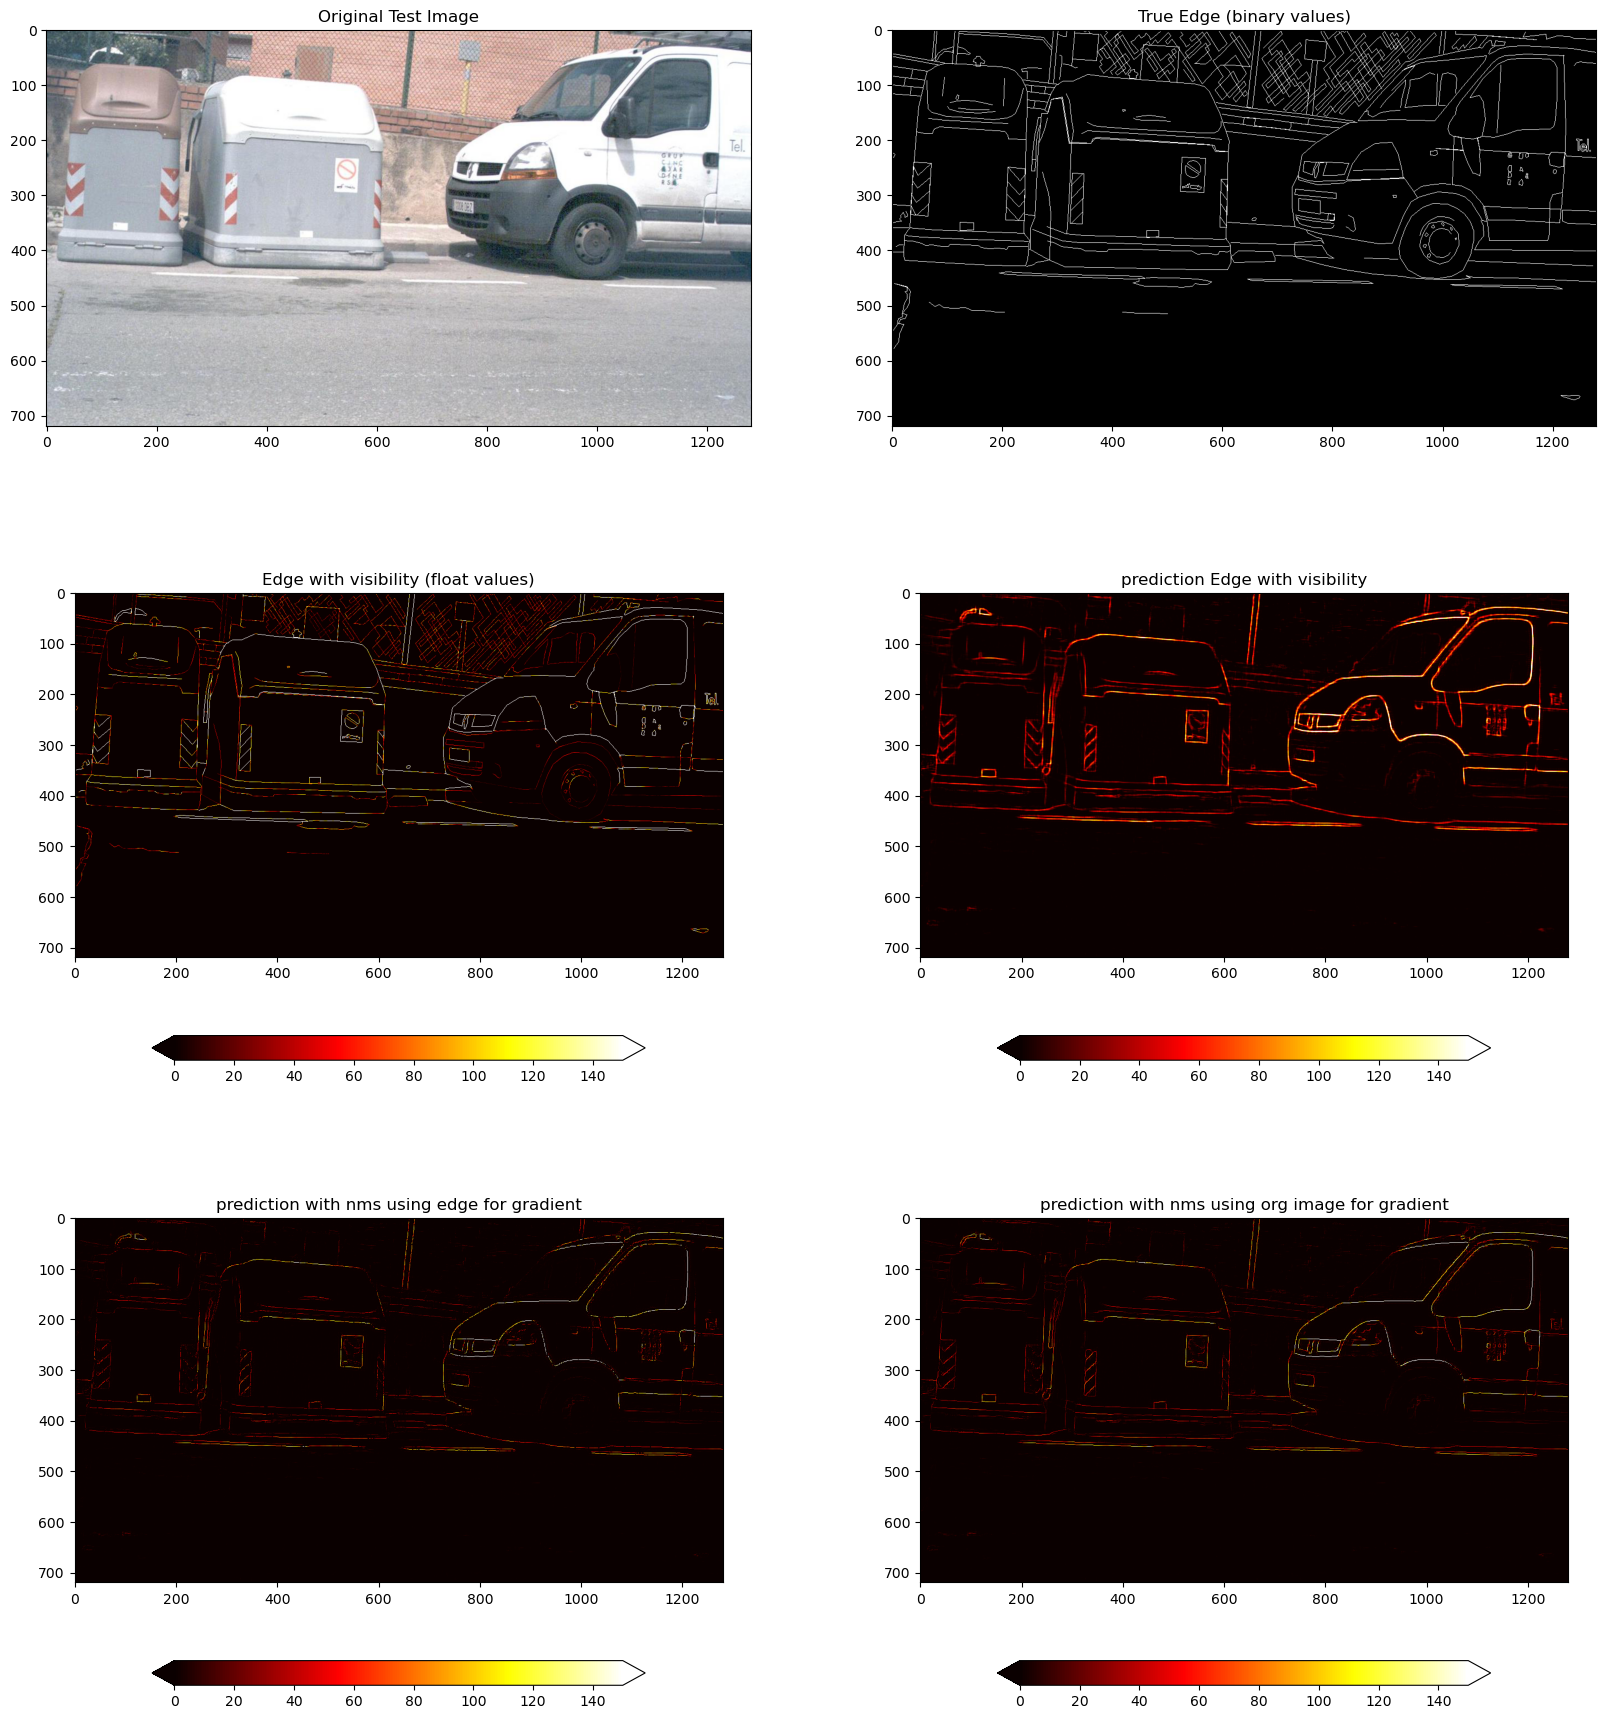

In [11]:
import matplotlib.pyplot as plt

# 显示原图和边缘图
fig, axs = plt.subplots(3, 2, figsize=(20, 23))
cmap_type="hot" # plasma, inferno, hot, seismic
vmin, vmax = 0, 150

axs[0,0].imshow(org_image)
axs[0,0].set_title("Original Test Image")

axs[0,1].imshow(edge, cmap="gray")
axs[0,1].set_title("True Edge (binary values)")

im1 = axs[1,0].imshow(gt_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=axs[1,0], shrink=0.7, location='bottom', extend='both')
axs[1,0].set_title("Edge with visibility (float values)")

im2 = axs[1,1].imshow(pred_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im2, ax=axs[1,1], shrink=0.7, location='bottom', extend='both')
axs[1,1].set_title("prediction Edge with visibility")

im3 = axs[2,0].imshow(pred_nms_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im3, ax=axs[2,0], shrink=0.7, location='bottom', extend='both')
axs[2,0].set_title("prediction with nms using edge for gradient")

im4 = axs[2,1].imshow(pred_nms_with_org_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im4, ax=axs[2,1], shrink=0.7, location='bottom', extend='both')
axs[2,1].set_title("prediction with nms using org image for gradient")

# plt.tight_layout()
plt.show()

# Gradient by Deriche

In [ ]:
gx, gy = deriche_gradient(yhat)
pred_nms_display = no_maxima_suppression(yhat, gx, gy)
gx, gy = deriche_gradient(img_tensor)
pred_nms_with_org_display = no_maxima_suppression(yhat, gx, gy)

917604it [01:10, 13079.17it/s]                            
917604it [01:10, 12938.57it/s]                            


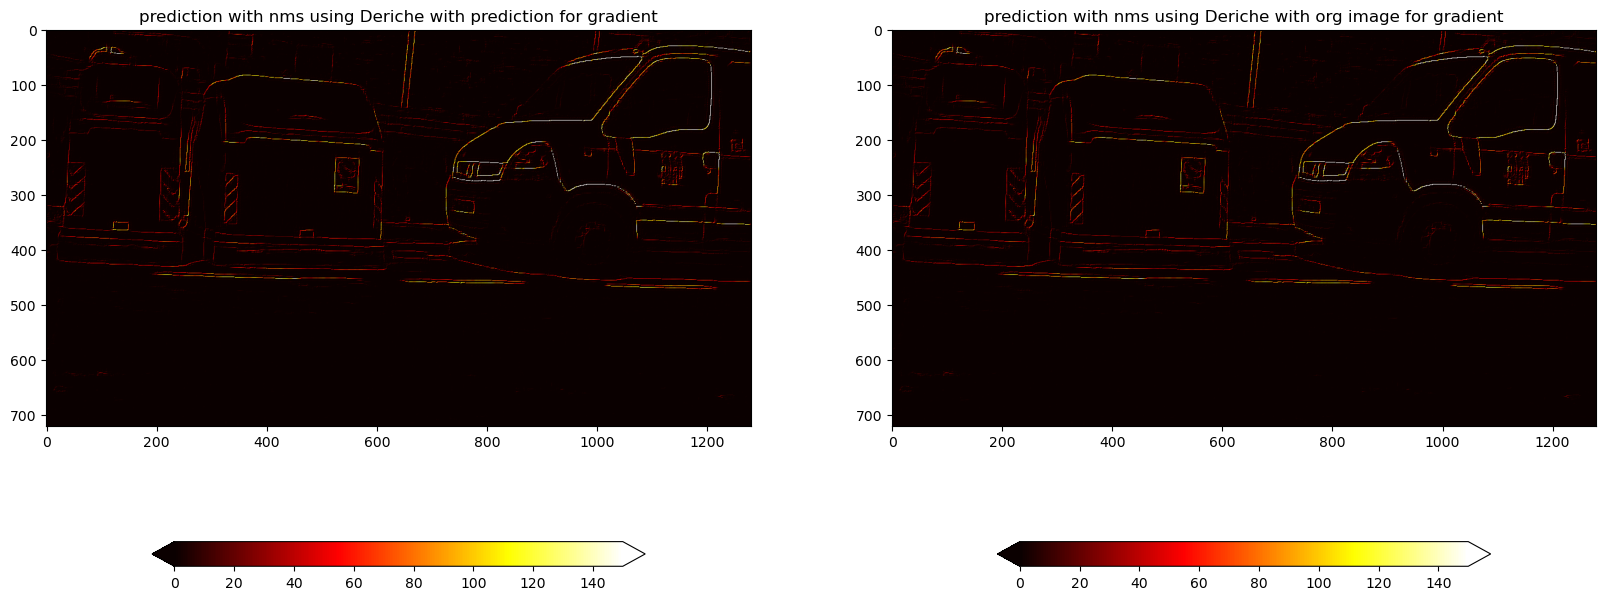

In [23]:
import matplotlib.pyplot as plt

# 显示原图和边缘图
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
cmap_type="hot" # plasma, inferno, hot, seismic
vmin, vmax = 0, 150

# axs[0,0].imshow(org_image)
# axs[0,0].set_title("Original Test Image")

# axs[0,1].imshow(edge, cmap="gray")
# axs[0,1].set_title("True Edge (binary values)")

# im1 = axs[1,0].imshow(gt_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
# fig.colorbar(im1, ax=axs[1,0], shrink=0.7, location='bottom', extend='both')
# axs[1,0].set_title("Edge with visibility (float values)")

# im2 = axs[1,1].imshow(pred_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
# fig.colorbar(im2, ax=axs[1,1], shrink=0.7, location='bottom', extend='both')
# axs[1,1].set_title("prediction Edge with visibility")

im3 = axs[0].imshow(pred_nms_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im3, ax=axs[0], shrink=0.7, location='bottom', extend='both')
axs[0].set_title("prediction with nms using Deriche with prediction for gradient")

im4 = axs[1].imshow(pred_nms_with_org_display, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im4, ax=axs[1], shrink=0.7, location='bottom', extend='both')
axs[1].set_title("prediction with nms using Deriche with org image for gradient")

# plt.tight_layout()
plt.show()